## AlexNet

### 前處理

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random

train_dir = "C:/Users/ycliou/Desktop/xray/8020/train"
categories = ["n", "p"]
test_dir = "C:/Users/ycliou/Desktop/xray/8020/test"
categories1 = ["n", "p"]

# 檢查是否成功加載並顯示第一張圖像
for category in categories:
    path = os.path.join(train_dir, category)
    for img in os.listdir(path):
        if img.endswith((".jpg", ".png", ".jpeg")):  # 只處理圖像文件
            img_array = cv2.imread(os.path.join(path, img))
            if img_array is not None:
                plt.imshow(img_array)
                plt.show()
            else:
                print(f"圖像 {img} 加載失敗")
        break
    break

In [3]:
IMG_SIZE = 224
# 創建訓練集列表
training_data = []

def create_training_data():
    for category in categories:
        path = os.path.join(train_dir, category)
        class_num = categories.index(category)
        for img in os.listdir(path):
            try:
                if img.endswith((".jpg", ".png", ".jpeg")):  # 只處理圖像文件
                    img_array = cv2.imread(os.path.join(path, img))
                    if img_array is not None:  # 檢查圖像是否成功加載
                        new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                        training_data.append([new_array, class_num])
                    else:
                        print(f"圖像 {img} 加載失敗")
            except Exception as e:
                print(f"處理圖像 {img} 時出錯: {str(e)}")

create_training_data()

# 創建測試集列表
testing_data = []

def create_testing_data():
    for category1 in categories1:
        path1 = os.path.join(test_dir, category1)
        class_num1 = categories1.index(category1)
        for img1 in os.listdir(path1):
            try:
                if img1.endswith((".jpg", ".png", ".jpeg")):  # 只处理图像文件
                    img_array1 = cv2.imread(os.path.join(path1, img1))
                    if img_array1 is not None:  # 检查图像是否成功加载
                        new_array1 = cv2.resize(img_array1, (IMG_SIZE, IMG_SIZE))
                        testing_data.append([new_array1, class_num1])
                    else:
                        print(f"圖像 {img1} 加載失敗")
            except Exception as e:
                print(f"處理圖像 {img1} 時出錯: {str(e)}")

create_testing_data()

In [4]:
# 隨機打亂訓練及測試集
random.shuffle(training_data)
random.shuffle(testing_data)

In [5]:
# 分別創建訓練集和測試集的特徵和標籤
X_train = []
y_train = []

X_test = []
y_test = []

for features_train, label_train in training_data:
    X_train.append(features_train)
    y_train.append(label_train)

X_train = np.array(X_train)
y_train = np.array(y_train)

X_train = X_train.reshape(X_train.shape[0], IMG_SIZE, IMG_SIZE, 3)

for features_test, label_test in testing_data:
    X_test.append(features_test)
    y_test.append(label_test)

X_test = np.array(X_test)
y_test = np.array(y_test)

X_test = X_test.reshape(X_test.shape[0], IMG_SIZE, IMG_SIZE, 3)

# 將像素進行歸一化
X_train = X_train / 255.0
X_test = X_test / 255.0

print("訓練集樣本數:", len(X_train))
print("測試集樣本數:", len(X_test))

訓練集樣本數: 5100
測試集樣本數: 1172


### 模型建立

#### 優化器：Adam

In [34]:
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping

IMG_SIZE = 224

# 建立二分類模型
model=keras.models.Sequential([
    keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', padding="valid", input_shape=(IMG_SIZE, IMG_SIZE,3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="valid"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="valid"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="valid"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="valid"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(4096,activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4096,activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1,activation='sigmoid')   
])

# 編譯模型
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 設定早停
early_stopping = EarlyStopping(monitor='val_loss', patience=100, min_delta=0.0001, restore_best_weights=True)

# 訓練模型
history = model.fit(X_train, y_train, batch_size=32, epochs=600, validation_data=(X_test,y_test), callbacks=[early_stopping], shuffle=True, verbose=2)

Epoch 1/600
160/160 - 5s - loss: 0.4498 - accuracy: 0.8555 - val_loss: 1.3390 - val_accuracy: 0.7372 - 5s/epoch - 30ms/step
Epoch 2/600
160/160 - 3s - loss: 0.2223 - accuracy: 0.9225 - val_loss: 0.6914 - val_accuracy: 0.7927 - 3s/epoch - 18ms/step
Epoch 3/600
160/160 - 3s - loss: 0.1963 - accuracy: 0.9263 - val_loss: 0.6397 - val_accuracy: 0.7816 - 3s/epoch - 16ms/step
Epoch 4/600
160/160 - 3s - loss: 0.1851 - accuracy: 0.9337 - val_loss: 0.2938 - val_accuracy: 0.8447 - 3s/epoch - 16ms/step
Epoch 5/600
160/160 - 2s - loss: 0.1636 - accuracy: 0.9418 - val_loss: 0.3111 - val_accuracy: 0.9096 - 2s/epoch - 16ms/step
Epoch 6/600
160/160 - 3s - loss: 0.1471 - accuracy: 0.9461 - val_loss: 0.3152 - val_accuracy: 0.8712 - 3s/epoch - 16ms/step
Epoch 7/600
160/160 - 3s - loss: 0.1440 - accuracy: 0.9445 - val_loss: 32.6767 - val_accuracy: 0.7372 - 3s/epoch - 16ms/step
Epoch 8/600
160/160 - 3s - loss: 0.1389 - accuracy: 0.9522 - val_loss: 0.1121 - val_accuracy: 0.9582 - 3s/epoch - 16ms/step
Epoch 9

#### 優化器：SGD

In [24]:
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping

IMG_SIZE = 224

# 建立二分類模型
model=keras.models.Sequential([
    keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', padding="valid", input_shape=(IMG_SIZE, IMG_SIZE,3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="valid"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="valid"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="valid"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="valid"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(4096,activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4096,activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1,activation='sigmoid')   
])

# 編譯模型
optimizer = keras.optimizers.SGD(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy']) 

# 設定早停
early_stopping = EarlyStopping(monitor='val_loss', patience=100, min_delta=0.0001, restore_best_weights=True)

# 訓練模型
history = model.fit(X_train, y_train, batch_size=32, epochs=600, validation_data=(X_test,y_test), callbacks=[early_stopping], shuffle=True, verbose=2)

Epoch 1/600
160/160 - 3s - loss: 0.4379 - accuracy: 0.7994 - val_loss: 0.6391 - val_accuracy: 0.7372 - 3s/epoch - 17ms/step
Epoch 2/600
160/160 - 2s - loss: 0.2705 - accuracy: 0.8937 - val_loss: 0.6898 - val_accuracy: 0.7372 - 2s/epoch - 12ms/step
Epoch 3/600
160/160 - 2s - loss: 0.2247 - accuracy: 0.9135 - val_loss: 0.4597 - val_accuracy: 0.7534 - 2s/epoch - 12ms/step
Epoch 4/600
160/160 - 2s - loss: 0.2021 - accuracy: 0.9237 - val_loss: 0.3545 - val_accuracy: 0.8208 - 2s/epoch - 12ms/step
Epoch 5/600
160/160 - 2s - loss: 0.1870 - accuracy: 0.9286 - val_loss: 1.0254 - val_accuracy: 0.4505 - 2s/epoch - 12ms/step
Epoch 6/600
160/160 - 2s - loss: 0.1586 - accuracy: 0.9404 - val_loss: 1.0597 - val_accuracy: 0.4906 - 2s/epoch - 12ms/step
Epoch 7/600
160/160 - 2s - loss: 0.1433 - accuracy: 0.9475 - val_loss: 1.2245 - val_accuracy: 0.7389 - 2s/epoch - 12ms/step
Epoch 8/600
160/160 - 2s - loss: 0.1317 - accuracy: 0.9500 - val_loss: 0.9549 - val_accuracy: 0.7372 - 2s/epoch - 12ms/step
Epoch 9/

### 指標

#### 優化器：Adam

In [35]:
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score

# 評估測試集（當前用作驗證）
val_loss, val_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"ADAM測試集 (用作驗證) 結果 - Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}")

ADAM測試集 (用作驗證) 結果 - Loss: 0.1121, Accuracy: 0.9582


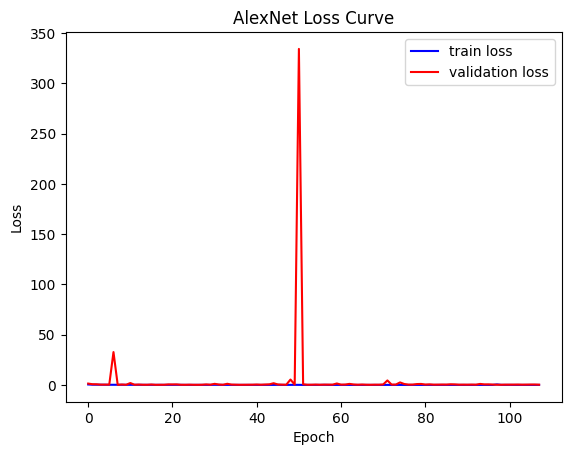

In [36]:
# Adam
plt.plot(history.history['loss'],'b',label = "train loss")
plt.plot(history.history['val_loss'],'r',label = "validation loss")
plt.title('AlexNet Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

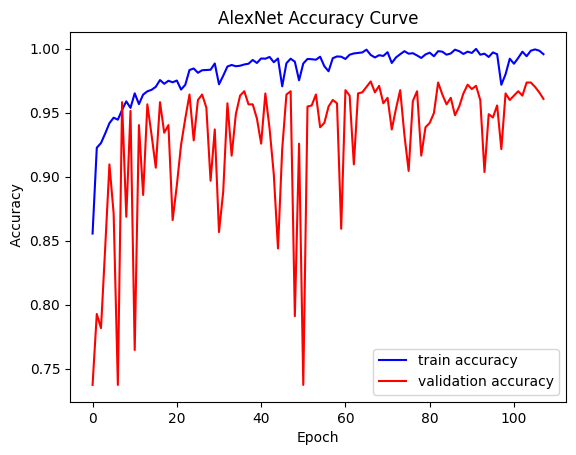

In [37]:
# Adam
plt.plot(history.history['accuracy'],'b',label = "train accuracy")
plt.plot(history.history['val_accuracy'],'r',label = "validation accuracy")
plt.title('AlexNet Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel(' Accuracy')
plt.legend()
plt.show()

37/37 [==============================] - 0s 8ms/step


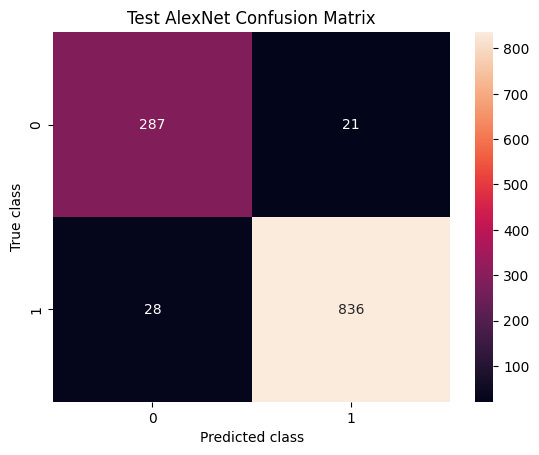

TP: 836, FP: 21, FN: 28, TN: 287
accuracy： 0.9581911262798635
precision： 0.9754959159859977
recall： 0.9675925925925926
f1 score： 0.9715281812899478
KAPPA： 0.89288139134068
sensitivity： 0.9675925925925926
specificity： 0.9318181818181818


In [38]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import seaborn as sns
# 進行預測
#predict = model.predict(X_test).argmax(axis=1)

# 進行預測，使用閾值 0.5 進行二分類
predict = (model.predict(X_test) > 0.5).astype("int32")

# 計算混淆矩陣
matrix = confusion_matrix(y_test, predict)

# 畫出混淆矩陣熱力圖
sns.heatmap(matrix, annot=True, fmt='d')
plt.title('Test AlexNet Confusion Matrix')
plt.xlabel('Predicted class')
plt.ylabel('True class')
plt.show()

# 提取 TP, FP, FN, TN
tp = matrix[1,1]  # True Positive
fp = matrix[0,1]  # False Positive
fn = matrix[1,0]  # False Negative
tn = matrix[0,0]  # True Negative

print(f"TP: {tp}, FP: {fp}, FN: {fn}, TN: {tn}")

# 模型指標
accuracy = (tp + tn) / (tp + fp + fn + tn)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1 = 2 * (precision * recall) / (precision + recall)

po = (tp + tn) / (tp + fp + fn + tn)
pe = ((tp + fp) * (tp + fn) + (tn + fp) * (tn + fn)) / (tp + fp + fn + tn) ** 2
kappa = (po - pe) / (1 - pe)

sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

print("accuracy：",accuracy)
print("precision：",precision)
print("recall：",recall)
print("f1 score：",f1)
print("KAPPA：",kappa)
print("sensitivity：",sensitivity)
print("specificity：",specificity)

In [17]:
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score

# 訓練集評估
train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
print(f"訓練集結果 - Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}")

# 預測訓練集的結果
y_train_pred_proba = model.predict(X_train).ravel()  # 預測概率
y_train_pred = (y_train_pred_proba > 0.5).astype("int32")  # 預測分類結果

# 顯示分類報告
print("\n訓練集分類報告:")
print(classification_report(y_train, y_train_pred))

# 顯示混淆矩陣
print("\n訓練集混淆矩陣:")
train_conf_matrix = confusion_matrix(y_train, y_train_pred)
print(train_conf_matrix)

# 計算精確度、召回率和F1分數
train_precision = precision_score(y_train, y_train_pred)
train_recall = recall_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred)

print(f"\n訓練集精確度: {train_precision:.4f}")
print(f"訓練集召回率: {train_recall:.4f}")
print(f"訓練集F1分數: {train_f1:.4f}")

# 使用驗證集（即 X_test 和 y_test）進行評估
val_loss, val_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"驗證集結果 - Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}")

# 預測驗證集的結果
y_val_pred_proba = model.predict(X_test).ravel()  # 預測概率
y_val_pred = (y_val_pred_proba > 0.5).astype("int32")  # 預測分類結果

# 顯示分類報告
print("\n分類報告:")
print(classification_report(y_test, y_val_pred))

# 顯示混淆矩陣
print("\n混淆矩陣:")
conf_matrix = confusion_matrix(y_test, y_val_pred)
print(conf_matrix)

# 計算精確度、召回率和F1分數
precision = precision_score(y_test, y_val_pred)
recall = recall_score(y_test, y_val_pred)
f1 = f1_score(y_test, y_val_pred)

print(f"\n精確度: {precision:.4f}")
print(f"召回率: {recall:.4f}")
print(f"F1分數: {f1:.4f}")


訓練集結果 - Loss: 0.0941, Accuracy: 0.9645
160/160 [==============================] - 1s 4ms/step

訓練集分類報告:
              precision    recall  f1-score   support

           0       0.96      0.97      0.96      2550
           1       0.97      0.96      0.96      2550

    accuracy                           0.96      5100
   macro avg       0.96      0.96      0.96      5100
weighted avg       0.96      0.96      0.96      5100


訓練集混淆矩陣:
[[2462   88]
 [  93 2457]]

訓練集精確度: 0.9654
訓練集召回率: 0.9635
訓練集F1分數: 0.9645
驗證集結果 - Loss: 0.1190, Accuracy: 0.9531
37/37 [==============================] - 0s 4ms/step

分類報告:
              precision    recall  f1-score   support

           0       0.89      0.94      0.91       308
           1       0.98      0.96      0.97       864

    accuracy                           0.95      1172
   macro avg       0.93      0.95      0.94      1172
weighted avg       0.95      0.95      0.95      1172


混淆矩陣:
[[289  19]
 [ 36 828]]

精確度: 0.9776
召回率: 0.9583
F1分數

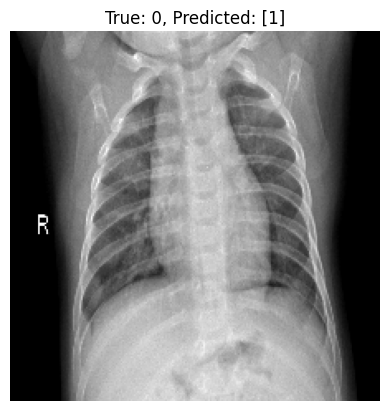

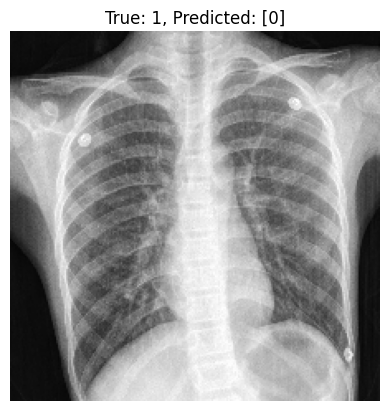

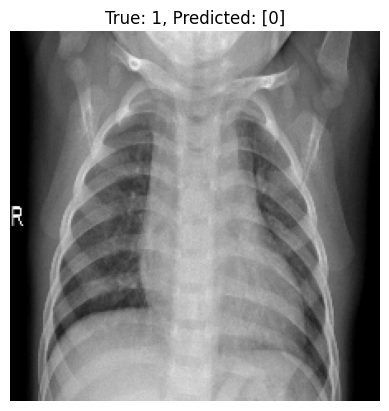

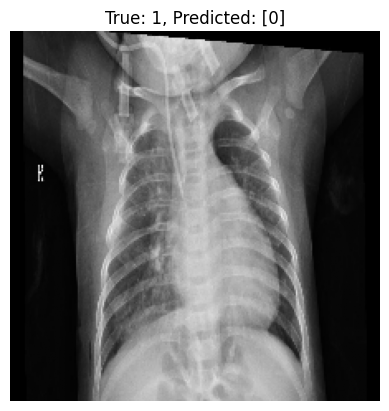

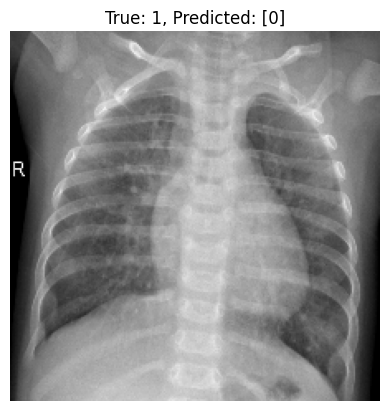

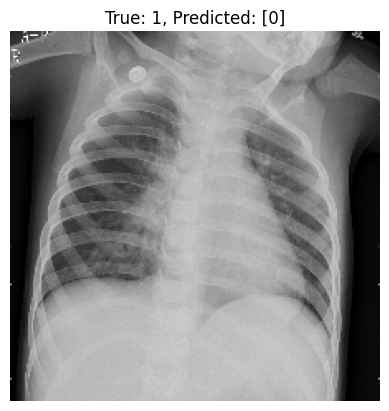

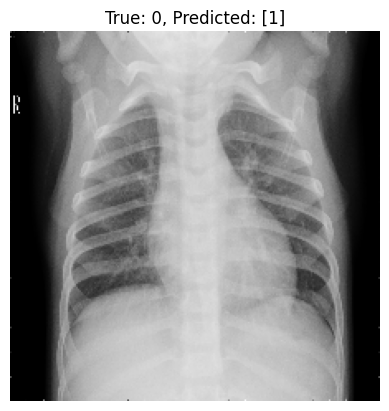

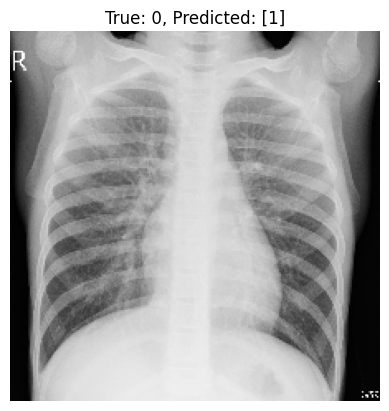

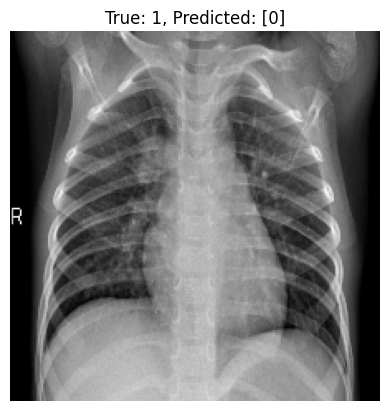

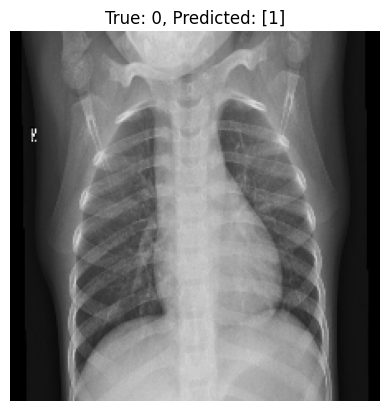

In [19]:
# 找到預測錯誤的樣本
errors = np.where(predict.flatten() != y_test)[0]

# 顯示錯誤樣本
for i in errors[:10]:  # 顯示前 10 個錯誤樣本
    plt.imshow(X_test[i])
    plt.title(f'True: {y_test[i]}, Predicted: {predict[i]}')
    plt.axis('off')
    plt.show()

#### 優化器：SGD

In [25]:
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score

# 評估測試集（當前用作驗證）
val_loss, val_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"SGD測試集 (用作驗證) 結果 - Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}")

SGD測試集 (用作驗證) 結果 - Loss: 0.1050, Accuracy: 0.9710


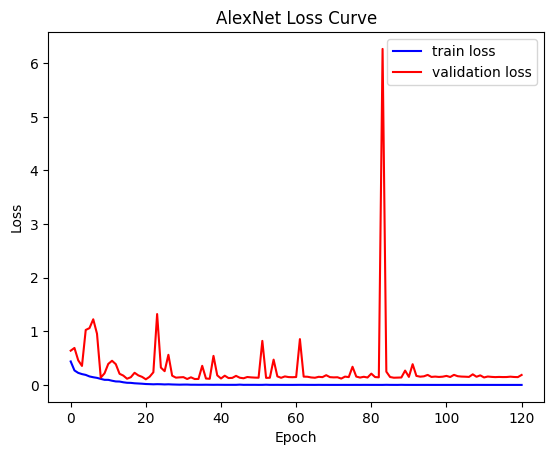

In [26]:
# SDG
plt.plot(history.history['loss'],'b',label = "train loss")
plt.plot(history.history['val_loss'],'r',label = "validation loss")
plt.title('AlexNet Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

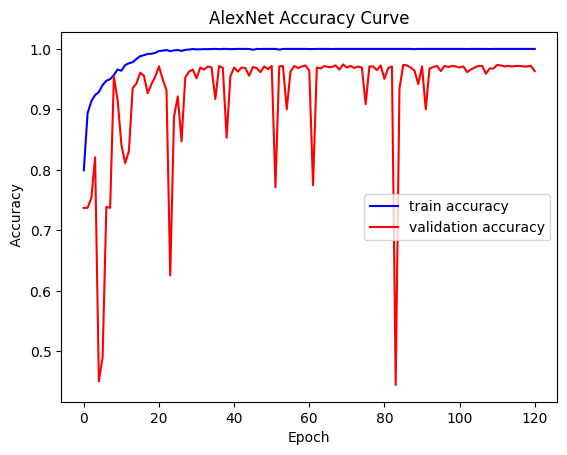

In [27]:
# SDG
plt.plot(history.history['accuracy'],'b',label = "train accuracy")
plt.plot(history.history['val_accuracy'],'r',label = "validation accuracy")
plt.title('AlexNet Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel(' Accuracy')
plt.legend()
plt.show()

37/37 [==============================] - 0s 7ms/step


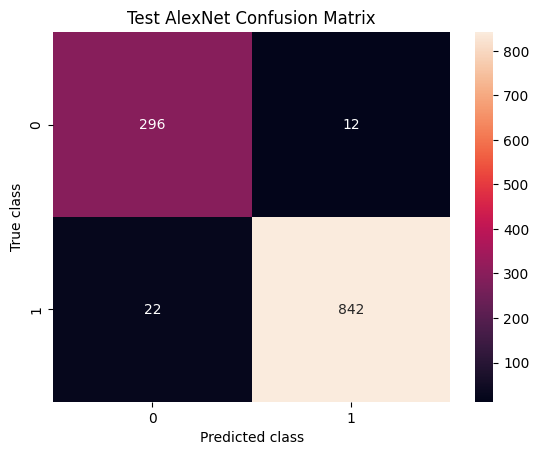

TP: 842, FP: 12, FN: 22, TN: 296
accuracy： 0.9709897610921502
precision： 0.9859484777517564
recall： 0.9745370370370371
f1 score： 0.9802095459837019
KAPPA： 0.925903336655609
sensitivity： 0.9745370370370371
specificity： 0.961038961038961


In [32]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import seaborn as sns

# 進行預測
#predict = model.predict(X_test).argmax(axis=1)

# 進行預測，使用閾值 0.5 進行二分類
predict = (model.predict(X_test) > 0.5).astype("int32")

# 計算混淆矩陣
matrix = confusion_matrix(y_test, predict)

# 畫出混淆矩陣熱力圖
sns.heatmap(matrix, annot=True, fmt='d')
plt.title('Test AlexNet Confusion Matrix')
plt.xlabel('Predicted class')
plt.ylabel('True class')
plt.show()

# 提取 TP, FP, FN, TN
tp = matrix[1,1]  # True Positive
fp = matrix[0,1]  # False Positive
fn = matrix[1,0]  # False Negative
tn = matrix[0,0]  # True Negative

print(f"TP: {tp}, FP: {fp}, FN: {fn}, TN: {tn}")

# 模型指標
accuracy = (tp + tn) / (tp + fp + fn + tn)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1 = 2 * (precision * recall) / (precision + recall)

po = (tp + tn) / (tp + fp + fn + tn)
pe = ((tp + fp) * (tp + fn) + (tn + fp) * (tn + fn)) / (tp + fp + fn + tn) ** 2
kappa = (po - pe) / (1 - pe)

sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

print("accuracy：",accuracy)
print("precision：",precision)
print("recall：",recall)
print("f1 score：",f1)
print("KAPPA：",kappa)
print("sensitivity：",sensitivity)
print("specificity：",specificity)

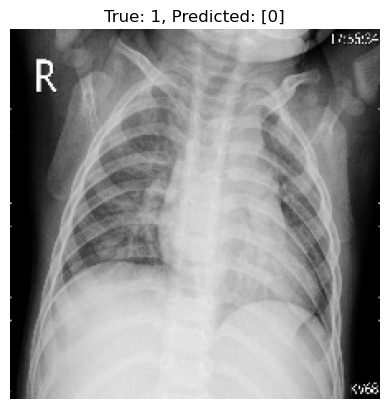

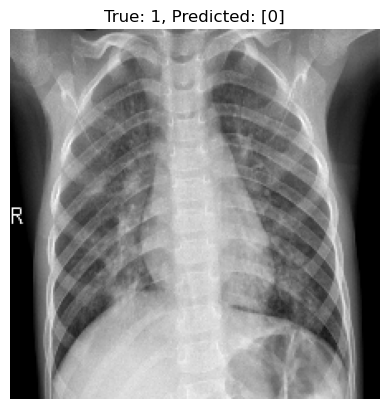

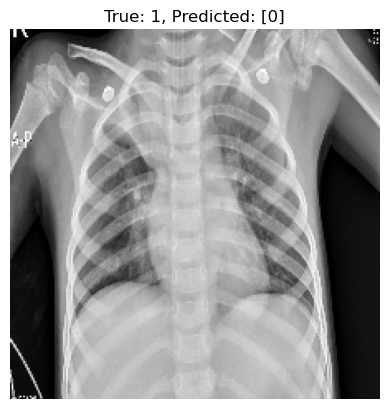

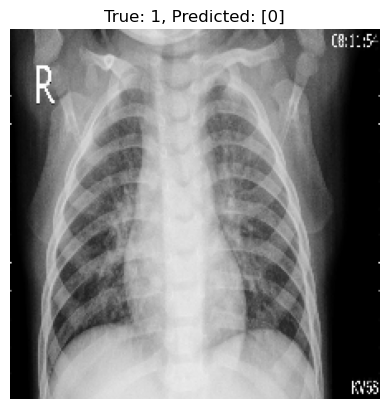

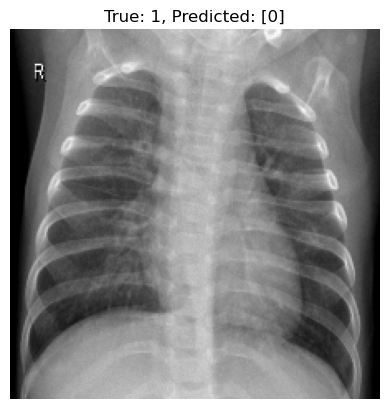

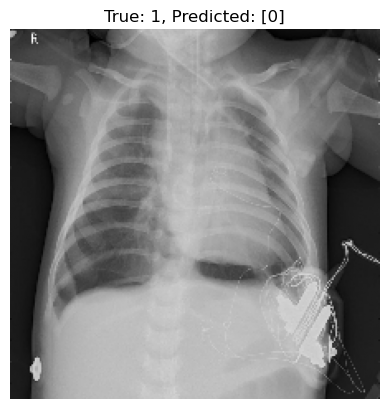

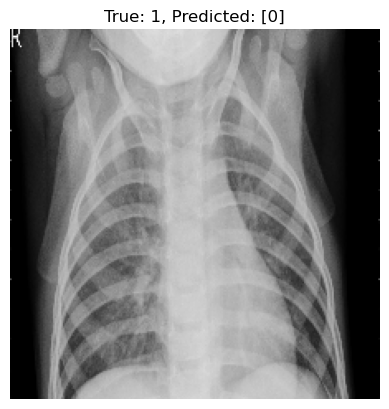

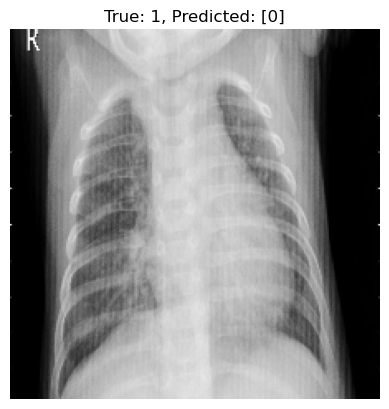

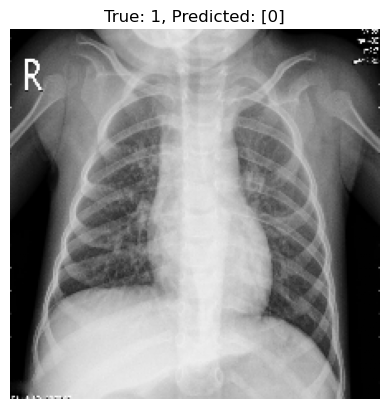

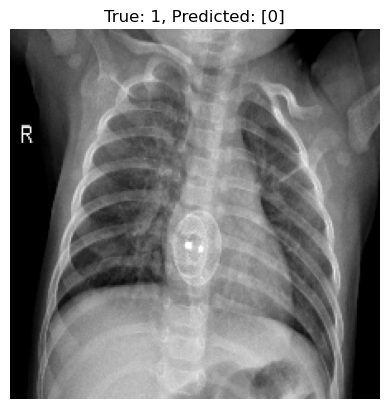

In [40]:
# 找到預測錯誤的樣本
errors = np.where(predict.flatten() != y_test)[0]

# 顯示錯誤樣本
for i in errors[:10]:  # 顯示前 10 個錯誤樣本
    plt.imshow(X_test[i])
    plt.title(f'True: {y_test[i]}, Predicted: {predict[i]}')
    plt.axis('off')
    plt.show()

## 五折

### 優化器：SDG

In [5]:
import os
import cv2
import random
import numpy as np
from tensorflow import keras
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc

# 參數設定
all_dir = "C:/Users/ycliou/Desktop/xray/5"  # 原始資料夾
categories = ["n", "p"]
IMG_SIZE = 224  
all_data = []

# 讀取影像並進行前處理
def create_all_data():
    for category in categories:
        path = os.path.join(all_dir, category)
        class_num = categories.index(category)
        for img_name in os.listdir(path):
            img_path = os.path.join(path, img_name)
            
            if not os.path.isfile(img_path):
                continue  # 跳過目錄和非圖片檔案
            
            if not img_name.lower().endswith(('.jpg', '.png', '.jpeg')):
                continue  # 跳過非圖片檔案
            
            img_array = cv2.imread(img_path)
            if img_array is None:
                print(f"Failed to load image: {img_path}")
                continue  # 無法加載圖片則跳過
            
            try:
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # 調整圖像大小
                all_data.append([new_array, class_num])  # 保存圖像資料和標籤
            except Exception as e:
                print(f"Error processing image {img_path}: {str(e)}")

create_all_data()

# 將所有圖像隨機打亂
random.shuffle(all_data)

# 分離出 X 和 Y，X 為圖像，Y 為標籤
X = []
Y = []

for features, label in all_data:
    X.append(features)
    Y.append(label)

X = np.array(X)
Y = np.array(Y)

# 正規化數據
X = X / 255.0

# 設定五折交叉驗證
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 設置參數
fold_accuracies = []
fold_losses = []
roc_data = []

# 儲存所有折的其他指標
precisions = []
recalls = []
f1_scores = []

# 儲存所有折的訓練歷史
all_train_losses = []
all_val_losses = []
all_train_accuracies = []
all_val_accuracies = []

# 五折交叉驗證
for fold, (train_index, val_index) in enumerate(kf.split(X, Y)):
    print(f"訓練第 {fold + 1} 折...")

    # 將數據劃分為訓練集和驗證集
    X_train_fold, X_val_fold = X[train_index], X[val_index]
    y_train_fold, y_val_fold = Y[train_index], Y[val_index]

   # 建立二分類模型
    model=keras.models.Sequential([
        keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', padding="valid", input_shape=(IMG_SIZE, IMG_SIZE,3)),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
        keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="valid"),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
        keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="valid"),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="valid"),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="valid"),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
        keras.layers.Flatten(),
        keras.layers.Dense(4096,activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(4096,activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(1,activation='sigmoid')   
    ])
    
    # 編譯模型
    optimizer = keras.optimizers.SGD(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy']) # loss=custom_loss
    
    # 設定早停
    early_stopping = EarlyStopping(monitor='val_loss', patience=100, min_delta=0.0001, restore_best_weights=True)
    
    # 訓練模型
    history = model.fit(X_train_fold, y_train_fold, batch_size=32, epochs=600, validation_data=(X_val_fold, y_val_fold), callbacks=[early_stopping], shuffle=True, verbose=2)
    
    # 保存每一折的結果
    val_loss, val_acc = model.evaluate(X_val_fold, y_val_fold)
    fold_accuracies.append(val_acc)
    fold_losses.append(val_loss)
    all_train_losses.append(history.history['loss'])
    all_val_losses.append(history.history['val_loss'])
    all_train_accuracies.append(history.history['accuracy'])
    all_val_accuracies.append(history.history['val_accuracy'])

    # 預測驗證集
    y_val_pred_proba = model.predict(X_val_fold).ravel()  # 驗證集預測概率
    y_val_pred = (y_val_pred_proba > 0.5).astype("int32")

    # 計算其他指標
    precision = precision_score(y_val_fold, y_val_pred)
    recall = recall_score(y_val_fold, y_val_pred)
    f1 = f1_score(y_val_fold, y_val_pred)

    # 保存指標
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)

    print(f"第 {fold + 1} 折 - accuracy：{val_acc:.4f}, loss：{val_loss:.4f}, precision: {precision:.4f}, recall: {recall:.4f}, F1-score: {f1:.4f}")

# 顯示最終結果(平均+-標準差)
print(f"Average accuracy: {np.mean(fold_accuracies):.4f} ± {np.std(fold_accuracies):.4f}")
print(f"Average loss: {np.mean(fold_losses):.4f} ± {np.std(fold_losses):.4f}")
print(f"Average precision: {np.mean(precisions):.4f} ± {np.std(precisions):.4f}")
print(f"Average recall: {np.mean(recalls):.4f} ± {np.std(recalls):.4f}")
print(f"Average F1-score: {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")

訓練第 1 折...
Epoch 1/600
147/147 - 7s - loss: 0.3850 - accuracy: 0.8301 - val_loss: 0.6191 - val_accuracy: 0.7295 - 7s/epoch - 44ms/step
Epoch 2/600
147/147 - 2s - loss: 0.2474 - accuracy: 0.8952 - val_loss: 0.6727 - val_accuracy: 0.7295 - 2s/epoch - 13ms/step
Epoch 3/600
147/147 - 2s - loss: 0.2171 - accuracy: 0.9150 - val_loss: 0.6410 - val_accuracy: 0.7295 - 2s/epoch - 13ms/step
Epoch 4/600
147/147 - 2s - loss: 0.1938 - accuracy: 0.9259 - val_loss: 1.3474 - val_accuracy: 0.7295 - 2s/epoch - 13ms/step
Epoch 5/600
147/147 - 2s - loss: 0.1642 - accuracy: 0.9368 - val_loss: 0.4815 - val_accuracy: 0.7875 - 2s/epoch - 13ms/step
Epoch 6/600
147/147 - 2s - loss: 0.1507 - accuracy: 0.9428 - val_loss: 0.9474 - val_accuracy: 0.7346 - 2s/epoch - 13ms/step
Epoch 7/600
147/147 - 2s - loss: 0.1390 - accuracy: 0.9485 - val_loss: 0.6979 - val_accuracy: 0.7346 - 2s/epoch - 13ms/step
Epoch 8/600
147/147 - 2s - loss: 0.1368 - accuracy: 0.9464 - val_loss: 0.8532 - val_accuracy: 0.5614 - 2s/epoch - 13ms/st